In [1]:
# torch and torchvision imports

import torch, torch.nn as nn, torch.optim as optim
from torchmetrics.classification import MultilabelAUROC
import numpy as np,  matplotlib.pyplot as plt, pandas as pd, pickle
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from ResnetModel import *
from transformer import *
writer = SummaryWriter()
# from google.colab import drive
# drive.mount('/gdrive')
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


2023-12-07 01:36:12.257809: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 01:36:12.290080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 01:36:12.290117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 01:36:12.291119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 01:36:12.296617: I tensorflow/core/platform/cpu_feature_guar

Device: cuda


### Loading and Preparing Data

In [2]:
X_train = torch.from_numpy(np.transpose(np.load('./data/X_train.npz')['arr_0'], axes = (0,2,1))).float()
X_test = torch.from_numpy(np.transpose(np.load('./data/X_val.npz')['arr_0'], axes = (0,2,1))).float()
y_train = pd.read_csv('./data/Y_train.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()
y_test = pd.read_csv('./data/Y_val.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()

/tmp/ipykernel_1168101/265309155.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  y_train = pd.read_csv('./data/Y_train.csv')[['Diag', 'Form', 'Rhythm']].to_numpy()


In [3]:
y_train = torch.from_numpy(y_train).int()
y_test = torch.from_numpy(y_test).int()

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
x = X_train[0:1]
print(x.shape)

torch.Size([1, 12, 1000])


In [ ]:


class_list = []
for classes in y_train:
    class_list += classes 
class_list = set(class_list)
class_list
diagSupclassDict = {val:i for i, val in enumerate(class_list)}
diagSupclassDict['Nodiag'] = 5
print(diagSupclassDict)

train_label_mapping = torch.zeros((X_train.shape[0], len(diagSupclassDict)), dtype=torch.uint8)
print(f"-"*(1+30+5+35))
for i, classes in enumerate(y_train):
    for diagclass in classes:
        train_label_mapping[i, diagSupclassDict[diagclass]] = 1
    if len(classes) == 0:
        train_label_mapping[i, diagSupclassDict['Nodiag']] = 1
    
    print(f"|  {str(y_train[i]):>30}  |  {str(train_label_mapping[i]):<30}   |")

test_label_mapping = torch.zeros((X_test.shape[0], len(diagSupclassDict)), dtype=torch.uint8)
print(f"-"*(1+30+5+35))
for i, classes in enumerate(y_test):
    for diagclass in classes:
        test_label_mapping[i, diagSupclassDict[diagclass]] = 1
    if len(classes) == 0:
        test_label_mapping[i, diagSupclassDict['Nodiag']] = 1
    
    print(f"|  {str(y_train[i]):>30}  |  {str(test_label_mapping[i]):<30}   |")

train_dataset = torch.utils.data.TensorDataset(X_train, train_label_mapping)
test_dataset = torch.utils.data.TensorDataset(X_test, test_label_mapping)
x = X_train[0:1]
print(x.shape)

### Creating the Transformer Model

In [9]:
"""Transformer needs X input as (seq_len, batch_size, channels)"""
model = Transformer(nhead=12, num_classes=3, hidden_size=128, depth=3, seq_length=200).to(device)
# resnetModel = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).to(device)

# resnetModel(X_train[0:1].to(device))
print(summary(model.to(device), (1,200,12)))

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [200, 3]                  --
├─PositionalEncoding: 1-1                     [1, 200, 12]              --
├─TransformerEncoder: 1-2                     [1, 200, 12]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 200, 12]              3,884
│    │    └─TransformerEncoderLayer: 3-2      [1, 200, 12]              3,884
│    │    └─TransformerEncoderLayer: 3-3      [1, 200, 12]              3,884
│    └─LayerNorm: 2-2                         [1, 200, 12]              24
├─Linear: 1-3                                 [1, 200, 64]              832
├─BatchNorm1d: 1-4                            [200, 12800]              25,600
├─Linear: 1-5                                 [200, 256]                3,277,056
├─BatchNorm1d: 1-6                            [200, 256]                51

In [ ]:
(4*1024-23.86)/37.66 #Max batch size

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle=True)

In [6]:
"""Test AUC metric"""
ml_auroc = MultilabelAUROC(num_labels=3, average="macro", thresholds=None)
# ml_auroc(model(X_train[0:10].to(device)), train_label_mapping[0:10].to(device).int())

### Finding Max Learning rate

In [13]:
criterion = nn.BCELoss()
epochs = 10
model = Transformer(nhead=12, num_classes=3, drop_p=0.25, hidden_size=128, depth=3, seq_length=200).to(device)
lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
np.random.randint(0, 1000-200)

In [ ]:
train_loss = []
lrs = []

for i, (signal, labels) in enumerate(train_loader):
    idx = np.random.randint(0, 1000-200)
    signal = (signal[:, :, idx:idx+200]).to(device).transpose(0,1).transpose(0,2)
    labels = labels.to(device)
    output = model(signal)
    loss = criterion(output, labels.float())
    optimizer.zero_grad()
    loss.backward()
    train_loss.append(loss.item())
    lrs.append(lr)
    lr *= 1.1

    for g in optimizer.param_groups:
        g['lr'] = lr 

    optimizer.step()

    if i > 200 or lr > 1:
        break

lrs = np.array(lrs)
train_loss = np.array(train_loss)

lr_max = lrs[np.where(train_loss == train_loss.min())[0]]

fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()


In [ ]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

In [ ]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

In [ ]:
lr_max

In [7]:
lr_max = 0.0025/10
lr = lr_max
epochs = 150
criterion = nn.BCELoss()
model = Transformer(nhead=12, num_classes=3, drop_p=0.25, hidden_size=128, depth=3, seq_length=200).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

for g in optimizer.param_groups:
    g['lr'] = lr

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


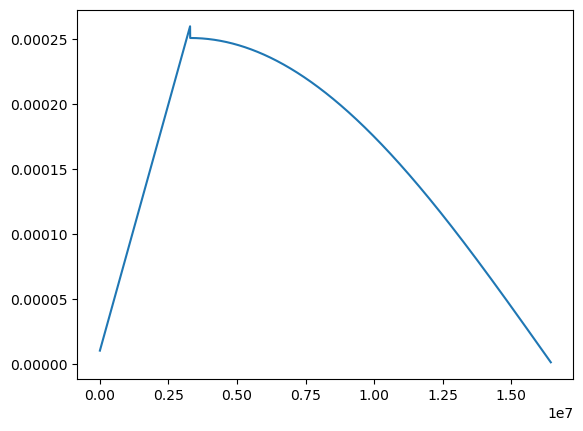

In [8]:
lrs = []
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs*800
T_0 = T_max/5 
for t in range(T_max):
    if t <= T_0:
        lr = 10**(-5) + (t/T_0)*lr_max  
    else: 
        lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6)
    lrs.append(lr)

fig = plt.figure()
plt.plot(lrs)
plt.show()


In [9]:
lr =lr_max

In [20]:
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
learning_rates = []
train_losses = []

for epoch in range(epochs):
    for i, (signal, labels) in enumerate(train_loader):
        for idx in range(800):
            signal = (signal[:, :, idx:idx+200]).to(device).transpose(0,1).transpose(0,2)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(signal)
            loss = criterion(outputs, labels.float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            if t <= T_0:
                lr = 10**(-4) + (t/T_0)*lr_max  
            else: 
                lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

            for g in optimizer.param_groups:
                g['lr'] = lr 
            learning_rates.append(lr)
            train_losses.append(loss.item())
            optimizer.step()
            t+=1
            
            train_AUC = ml_auroc(outputs, labels.int())
            writer.add_scalar("Train_Loss", loss, t)
            writer.add_scalar("Learning rate", lr, t)
            writer.add_scalar("Batch Train AUC", train_AUC, t)

        if i%100 == 0:
            print(f"Step: {i+1}/{len(train_loader)}  |  Train loss: {loss.item():.4f}  |  Train AUC: {train_AUC:.4f}")
           

    # model.eval()
    test_auc = 0
    with torch.no_grad():
        for i, (signal, labels) in enumerate(test_loader):
            idx = np.random.randint(0, 1000-200)
            signal = (signal[:, :, idx:idx+200]).to(device).transpose(0,1).transpose(0,2)
            labels = labels.to(device)
            outputs = model(signal)
            test_auc += ml_auroc(outputs, labels.int())
        test_auc /= len(test_loader)
    writer.add_scalar("Test AUC", test_auc, epoch)

RuntimeError: The size of tensor a (128) must match the size of tensor b (12) at non-singleton dimension 2

In [11]:
signal.shape

torch.Size([11, 200, 128])

In [ ]:
signal.shape

torch.Size([11, 200, 128])

In [16]:
outputs.shape

torch.Size([128, 3])

In [18]:
labels.shape

torch.Size([128, 3])

In [19]:
i

0

In [15]:
train_loader.__iter__().__next__()[0].transpose(0,1).transpose(1,2).shape

torch.Size([12, 1000, 128])

In [ ]:
model.eval()
test_Auc = 0
with torch.no_grad():
    for i, (signal, labels) in enumerate(test_loader):
        signal = signal.to(device); labels = labels.to(device)
        outputs = model(signal)
        test_Auc += ml_auroc(outputs, labels.int())

test_Auc /= len(test_loader)
test_Auc
        

In [ ]:
import pickle

In [ ]:
with open('Transformer_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len=1000, emb_size=12):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-np.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Transformer):
    def __init__(self, emb_size=12, nhead=6, depth=6, hidden_size=128, seq_length=1000, num_classes=5):
        super(Transformer, self).__init__(d_model=emb_size, nhead=nhead, num_encoder_layers=depth, num_decoder_layers=depth, dim_feedforward=hidden_size)
    
        self.pos_encoder = PositionalEncoding(seq_length, emb_size)
        self.decoder = nn.Linear(emb_size, 256)
        self.linear1 = nn.Linear(256, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, num_classes)
        
    def __forward_impl(self, x):
        #x = self.pos_encoder(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.decoder(x)
        x = torch.relu(x)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        x = torch.sigmoid(x)
        return x
    
    def forward(self, x):
        return self.__forward_impl(x)
    
model = Transformer(nhead=6, hidden_size=512, depth=3).to(device)

model(X_train[0].T.unsqueeze(0))

In [ ]:
X_train[0].T.shape

In [ ]:
model = Transformer(nhead=6, hidden_size=512, depth=3).to(device)
print(summary(model, [1000, 12]))

In [ ]:
summary(model.to(device), (1,1000, 12))